# Spherical Mass Model Tutorial
This tutorial will demonstrate the basic functionality of the spherical atmospheric mass model. For more details about the simulation and analysis pipeline, see **Atmospheric Response for MeV Gamma Rays Observed with Balloon-Borne Detectors (Karwin+24 in prep)**. 

Imports:

In [1]:
from cosi_atmosphere.response.AtmosphericProfile import Atmosphere
from cosi_atmosphere.response.MassModels import MakeMassModels
from cosi_atmosphere.response.RunSims import Simulate
from cosi_atmosphere.response.ProcessSphericalSims import ProcessSpherical
import numpy as np
import os

This tutorial requires two files, which contain the photon data for a simulation using 1e7 photons. The files are hosted on wasabi, and they can be downloaded using the two cells below.

In [ ]:
# File size: ~ 1GB
os.system("AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-Atmosphere/Spherical_Mass_Model_Tutorial/event_list_combined.dat --endpoint-url=https://s3.us-west-1.wasabisys.com event_list_combined.dat")

In [ ]:
# File size: ~ 1.2GB
os.system("AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-Atmosphere/Spherical_Mass_Model_Tutorial/all_thrown_events_combined.dat --endpoint-url=https://s3.us-west-1.wasabisys.com all_thrown_events_combined.dat")

## Make mass model
First, we need a model of the atmosphere. In general, this is dependent on location (latitude, longitude, altitude), time (year and day), and solar and geomagnetic activity levels. For our model we use a representative date, geographical location, and altitude from the COSI balloon flight.

In [2]:
instance = Atmosphere()
date = np.array(['2016-06-13 12:00:00'], dtype="datetime64[h]")
lat = -5.66
lon = -107.38
alts = np.linspace(0, 200, 2001) # km; spacing is 0.1 km (100 m) 
atm_model = instance.get_atm_profile("rep_atm_model.dat",date,lon,lat,alts)

The atmospheric model specifies the altitude profile of the number density for the primary species of the atmosphere (i.e. nitrogen, oxygen, argon, and helium). Let's take a look at the first few lines of the output file:

In [3]:
%%capture
os.system("head -n 5 rep_atm_model.dat")

altitude[km]	mass_density[kg/m3]	N2[m-3]	O2[m-3]	O[m-3]	He[m-3]	H[m-3]	Ar[m-3]	N[m-3]	anomalous_oxygen[m-3]	NO[m-3]	Temperature[k]
0.000000e+00	1.176653e+00	1.911429e+25	5.125639e+24	0.000000e+00	1.272904e+20	0.000000e+00	2.284374e+23	0.000000e+00	0.000000e+00	0.000000e+00	2.966827e+02
1.000000e-01	1.164742e+00	1.892081e+25	5.073756e+24	0.000000e+00	1.260020e+20	0.000000e+00	2.261251e+23	0.000000e+00	0.000000e+00	0.000000e+00	2.962918e+02
2.000000e-01	1.152961e+00	1.872944e+25	5.022437e+24	0.000000e+00	1.247275e+20	0.000000e+00	2.238379e+23	0.000000e+00	0.000000e+00	0.000000e+00	2.958947e+02
3.000000e-01	1.141304e+00	1.854006e+25	4.971656e+24	0.000000e+00	1.234664e+20	0.000000e+00	2.215747e+23	0.000000e+00	0.000000e+00	0.000000e+00	2.954918e+02


Now we can make our mass model. Let's first take a look at the atmospheric profiles:

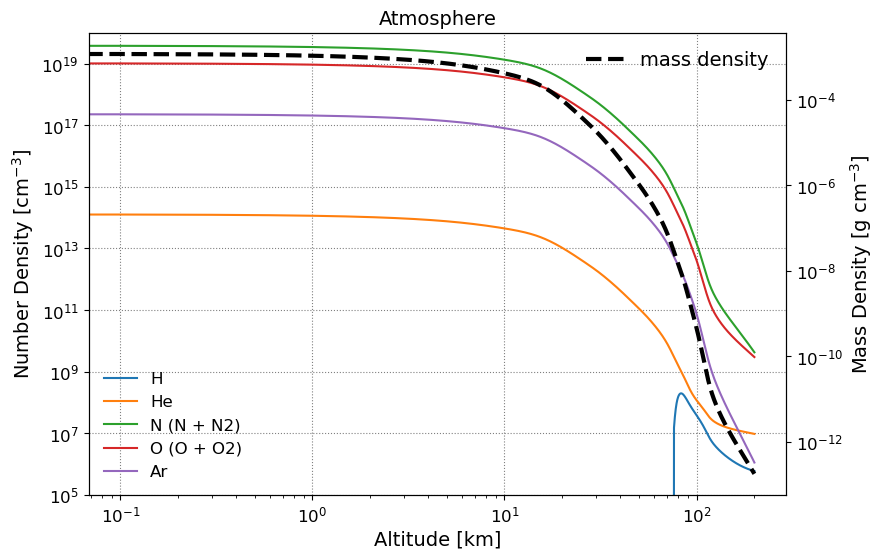

In [4]:
instance = MakeMassModels("rep_atm_model.dat")
instance.plot_atmosphere()

We'll use the spherical mass model, which consists of spherical shells with a thickness of 100 meters (as defined in the atmospheric profile). In order to track photons, we'll place our watched volume (consisting of a spherical shell) at an altitude of 33.5 km. We can use different altitudes if we want. Note that the spherical shells are defined relative to Earth's radius. 

In [5]:
instance.spherical_model(33.5)

Using shell thickness [cm]: 10000.0
Watch index: 335


The mass model is written to a standard MEGAlib geo file. Let's take a look at the first 50 lines:

In [6]:
%%capture
os.system("head -n 50 atmosphere.geo")

# Atmosphere model

Name AtmoshpereModel

# Surrounding sphere:
SurroundingSphere 657800000.0 0 0 0 657800000.0
ShowSurroundingSphere true

Volume World
World.Material Vacuum
World.Shape BOX 10240000000.000000 10240000000.000000 10240000000.000000
World.Visibility 1
World.Position 0 0 0
World.Mother 0

Include $(MEGALIB)/resource/examples/geomega/materials/Materials.geo

Material MaterialSlice_0_1
MaterialSlice_0_1.Density 0.001176653
MaterialSlice_0_1.ComponentByAtoms He 2
MaterialSlice_0_1.ComponentByAtoms N 784845
MaterialSlice_0_1.ComponentByAtoms O 210462
MaterialSlice_0_1.ComponentByAtoms Ar 4689

Volume VolumeSlice_0_1
VolumeSlice_0_1.Material MaterialSlice_0_1
VolumeSlice_0_1.Shape SPHERE 637800000.0 637810000.0
VolumeSlice_0_1.Visibility  0
VolumeSlice_0_1.Position 0 0 0
VolumeSlice_0_1.Color 7
VolumeSlice_0_1.Mother World

Material MaterialSlice_1_2
MaterialSlice_1_2.Density 0.0011647419999999999
MaterialSlice_1_2.ComponentByAtoms He 2
MaterialSlice_1_2.ComponentByAtoms N 784

The watched volume is specified at the end of the file. Let's take a look:

In [7]:
%%capture
os.system("tail -n 8 atmosphere.geo")


Volume TestSphere
TestSphere.Material MaterialSlice_335_336
TestSphere.Shape Sphere 641150000.0 641160000.0
TestSphere.Visibility 1
TestSphere.Position 0 0 0
TestSphere.Color 2
TestSphere.Mother VolumeSlice_335_336


## Run Simulations
Now we can run the simulations. We simulate an isotropic source with a flat energy spectrum (i.e. constant number of photons per energy bin) between 10 keV - 10 MeV. The source is simulated using a surrounding sphere with a radius of 200 km. The simulations should use at least 1e7 photons, but here we'll just simulate 100, just as a simple demonstration. 

In [8]:
instance = Simulate()
instance.run_sim("Atmosphere_Isotropic.source")


**************************************************************************
*                                                                        *
*                Cosima - the cosmic simulator of MEGAlib                *
*                                                                        *
*             This program is part of MEGAlib version 3.99.02            *
*                (C) by Andreas Zoglauer and contributors                *
*                                                                        *
*                      Master reference for MEGAlib:                     *
*            A. Zoglauer et al., NewAR 50 (7-8), 629-632, 2006           *
*                                                                        *
*            For more information about MEGAlib please visit:            *
*                        http://megalibtoolkit.com                       *
*                                                                        *
************************

Now we need to parse the sim file to get our photon lists. This will produce two dat files: one with the photon data for all thrown events (all_thrown_events.dat), and another with the photon data for the events that crossed the watched volume (event_list.dat):

In [9]:
instance.parse_sim_file("Atmosphere_Isotropic.inc1.id1.sim")

## Make Response File
The next step is to bin the simulations and write the response file. For this step, we'll use a simulation with 1e7 photons (which have been precomputed). We have to specify the altitude of our watched volume, which is 33.5 km (effectively 33.6 because of the shell thickness).    

In [2]:
instance = ProcessSpherical(33.6, all_events_file="all_thrown_events_combined.dat", measured_events_file="event_list_combined.dat")
instance.bin_sim("atm_response_33p5km.hdf5")

/zfs/astrohe/ckarwin/My_Class_Library/COSI/cosi-atmosphere/cosi_atmosphere/response/ProcessSphericalSims.py:273: RuntimeWarning: invalid value encountered in sqrt
  sqrt = np.sqrt( dp**2 - norm(u,axis=1)**2 * (norm(o,axis=1)**2 - r**2) )



Finding intersection...
Number of photons with no solution: 499940


Total number of initial events: 10000000
Total number of unmeasured events: 1467541
Number of undefined incident angles: 468848


Theta bins:
[  0.   4.   8.  12.  16.  20.  24.  28.  32.  36.  40.  44.  48.  52.
  56.  60.  64.  68.  72.  76.  80.  84.  88.  92.  96. 100.]

Using NSIDE 16
Approximate resolution at NSIDE 16 is 3.7 deg

Number of simulated events: 10000000
Number of events that reached watched volume: 8532459


## Working with a Response File
Once we have a response file, we can start by loading it directly. For example, the response file can be loaded as follows:

In [3]:
instance.load_response("atm_response_33p5km.hdf5")

Below we show some more options for working with a response file.

### Make diagnostic plots 
Note that numerous plots are made by default. We can turn off any of the plots if we want. See the API for more information. 

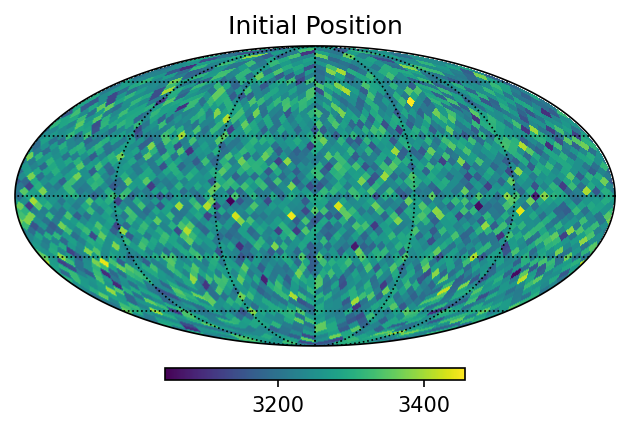

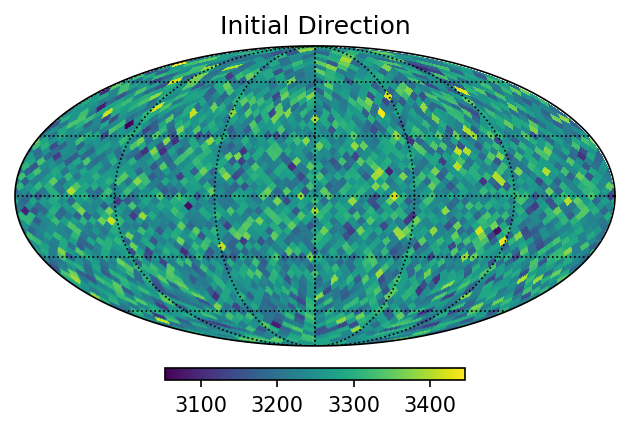

/zfs/astrohe/ckarwin/My_Class_Library/COSI/cosi-atmosphere/cosi_atmosphere/response/ProcessSphericalSims.py:584: RuntimeWarning: invalid value encountered in sqrt
  rdisk = np.sqrt(self.radial_bins**2 - rsphere**2)


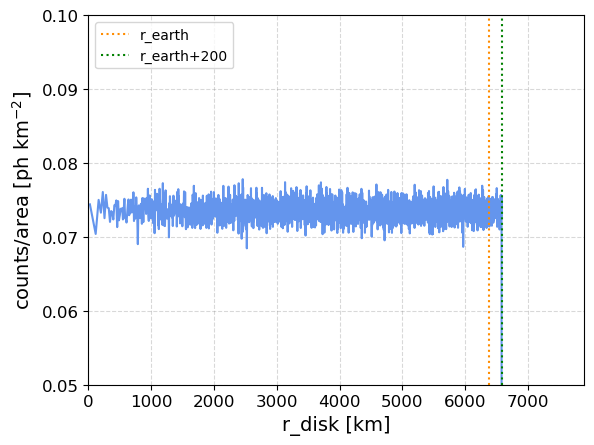

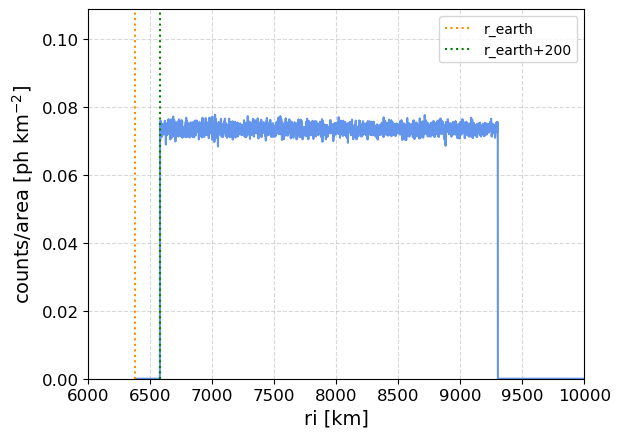

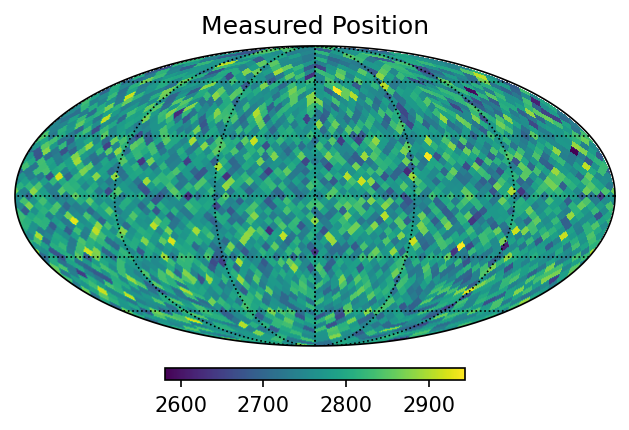

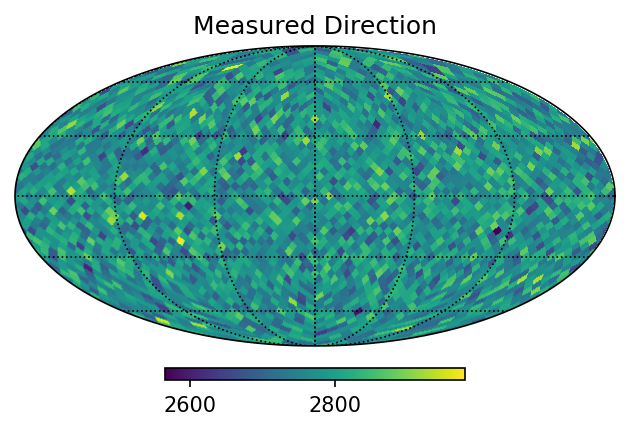

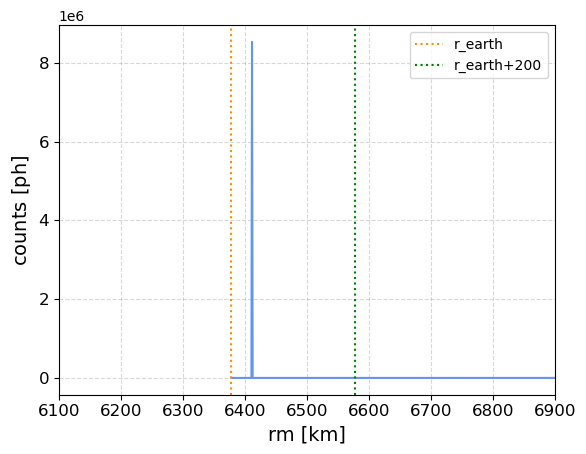


calculation of uniform flux through hemisphere:
radius of hemisphere [km]: 6411.600000000001
mean rate from surrounding sphere disk [ph/km^2]: 0.07356179254201645



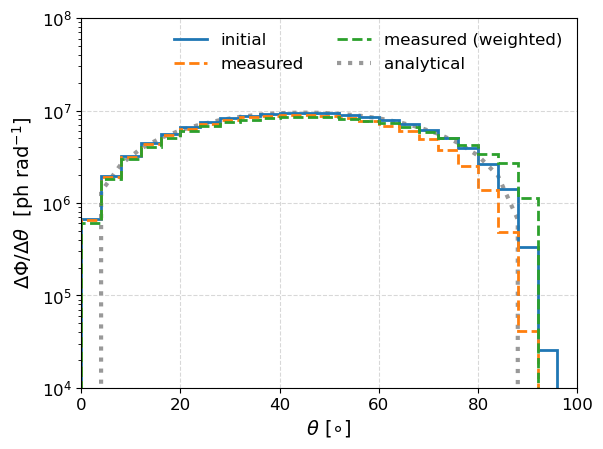

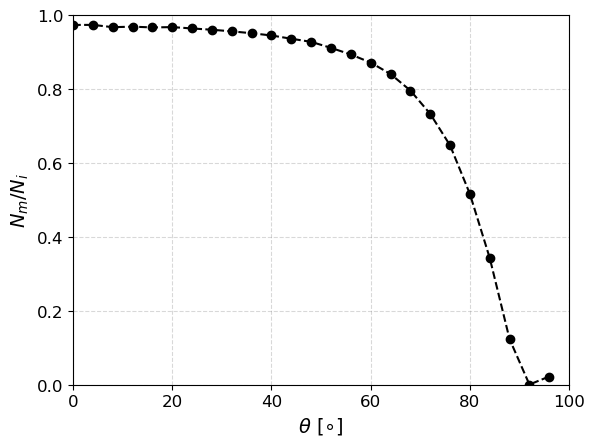

Using incident angle of 50 deg
Corresponding to angular bin 12
Using energy of 8000 keV
Corresponding to energy bin 15


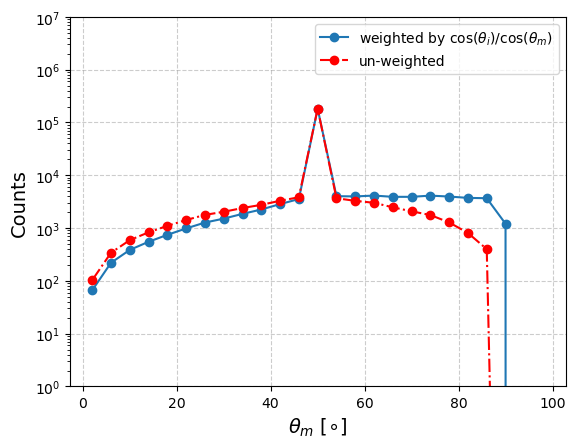

Initial energy distribution:
underflow bin: 0.0
overflow bin: 0.0
Measured energy distribution
underflow bin: 35.0
overflow bin: 0.0


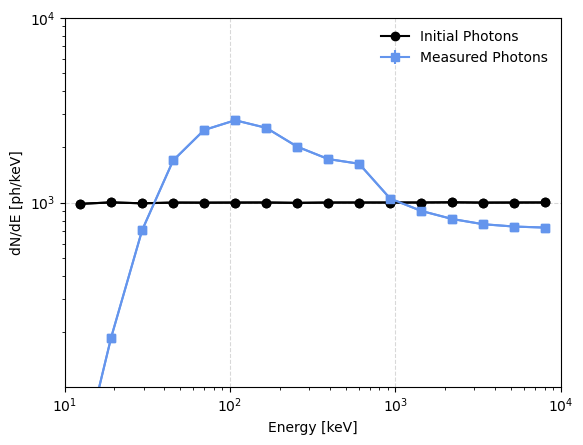


Number of starting photons: 10000000.0
Number of measured photons: 8532424.0



In [4]:
instance.make_scattering_plots(rsp_file="atm_response_33p5km.hdf5", ang_dist=[50,8000], pos_init=False, pos_meas=False, pos_proj=False)

### Make energy dispersion matrices
We'll use an off-axis angle of 50 degrees. This will make energy dispersion matrices for both the transmitted and direct components, as well as the total. It will also make the detection fraction, which is equivalent to the transmission probability for the transmitted component.


Total number of photons in response normalization:
9531147.0

plotting transmitted edisp matrix...


/zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/histpy/histogram.py:1301: RuntimeWarning: divide by zero encountered in divide
  self._contents = operation(self.full_contents, other)
/zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/histpy/histogram.py:1301: RuntimeWarning: invalid value encountered in divide
  self._contents = operation(self.full_contents, other)


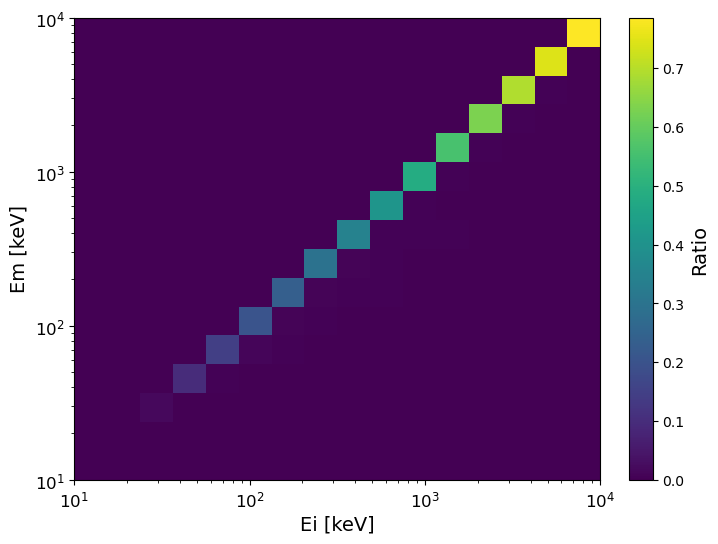

plotting scattered edisp matrix...


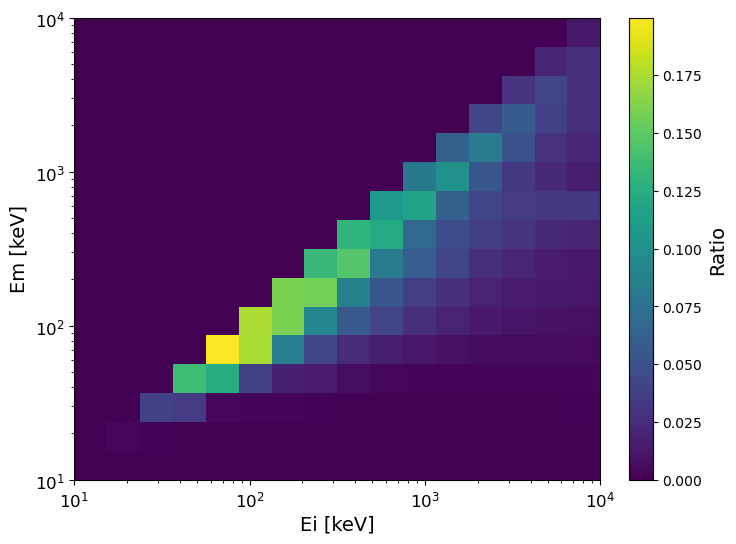

plotting total edisp matrix...


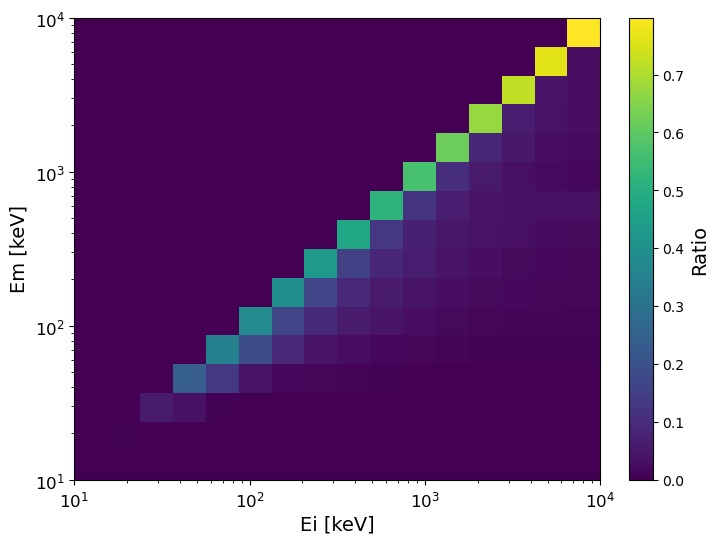

plotting transmission probability...


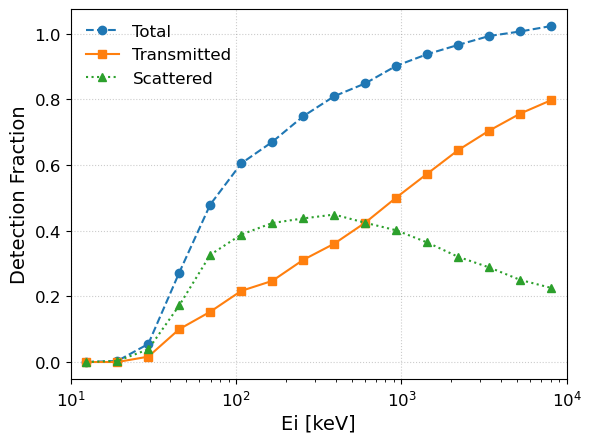

In [5]:
instance.get_total_edisp_matrix(50,rsp_file="atm_response_33p5km.hdf5")

### Calculate correction factors
After the energy dispersion matrices have been calcualted, we can calculate the correction factor and correction factor ratio. Let's use a power law spectral model with an index of 2:

/zfs/astrohe/ckarwin/My_Class_Library/COSI/cosi-atmosphere/cosi_atmosphere/response/ProcessSims.py:846: RuntimeWarning: divide by zero encountered in divide
  c_ratio = c_total/c_beam


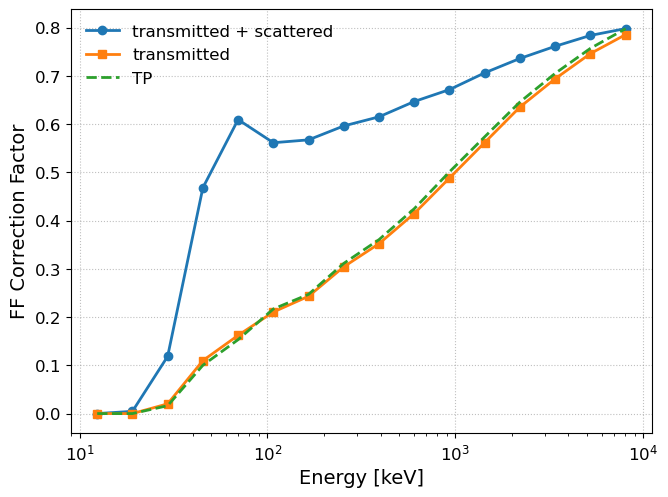

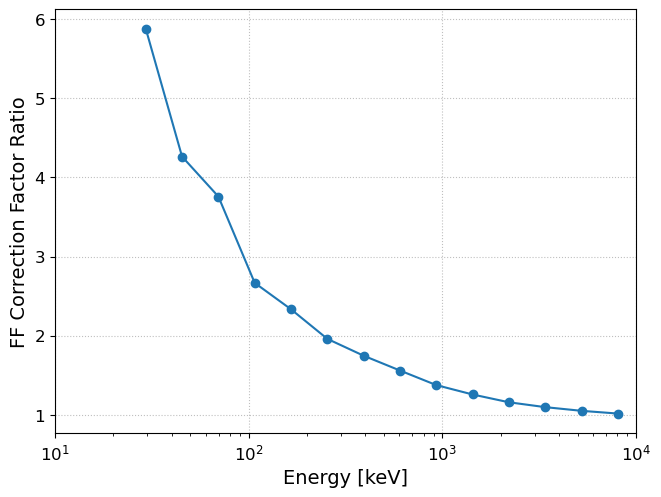

In [6]:
model_flux=instance.PL_interp(2)
instance.ff_correction(model_flux,"output")